In [1]:
import pandas as pd
import logging
import matplotlib.pyplot as plt
import numpy as np

# create an instance of the logger
logger = logging.getLogger()

# Change current directory to parent directory
import os
os.chdir("..")

### Getting the SCADA DATA

In [3]:
# Define global variables
RAW_SCADA_DATA = 'data/raw/scada.csv'

# Attempt to load the file with a try-except block
try:
    # Check if the file exists
    if os.path.exists(RAW_SCADA_DATA):
        # Load the Excel file
        scada_data= pd.read_csv(RAW_SCADA_DATA)
        print("File loaded successfully.")
    else:
        raise FileNotFoundError(f"File not found: {RAW_SCADA_DATA}")
except FileNotFoundError as fnf_error:
    print(fnf_error)
except Exception as e:
    print(f"An error occurred while reading the file: {e}")

File loaded successfully.


### WEC: Production kWh over time (Cumulative)

<Axes: xlabel='DateTime'>

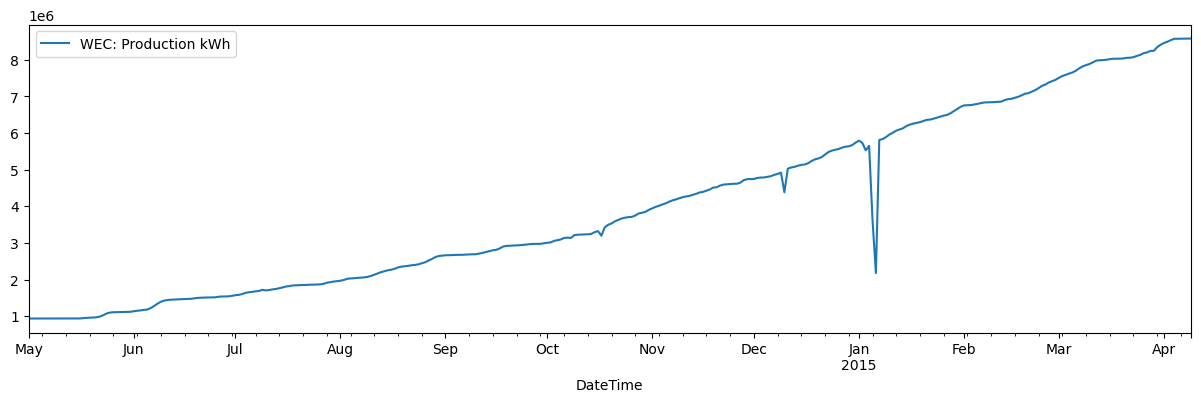

In [9]:
scada_data.resample('D', on='DateTime').mean().plot(y='WEC: Production kWh', figsize=(15,4))


### WEC: ava. windspeed over time

<Axes: xlabel='DateTime'>

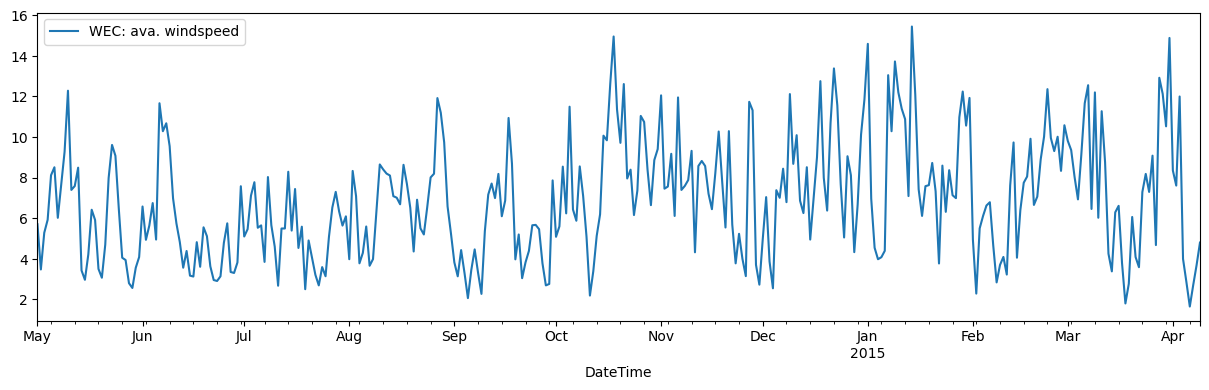

In [10]:
scada_data.resample('D', on='DateTime').mean().plot(y='WEC: ava. windspeed', figsize=(15,4))


### WEC: max. windspeed over time

<Axes: xlabel='DateTime'>

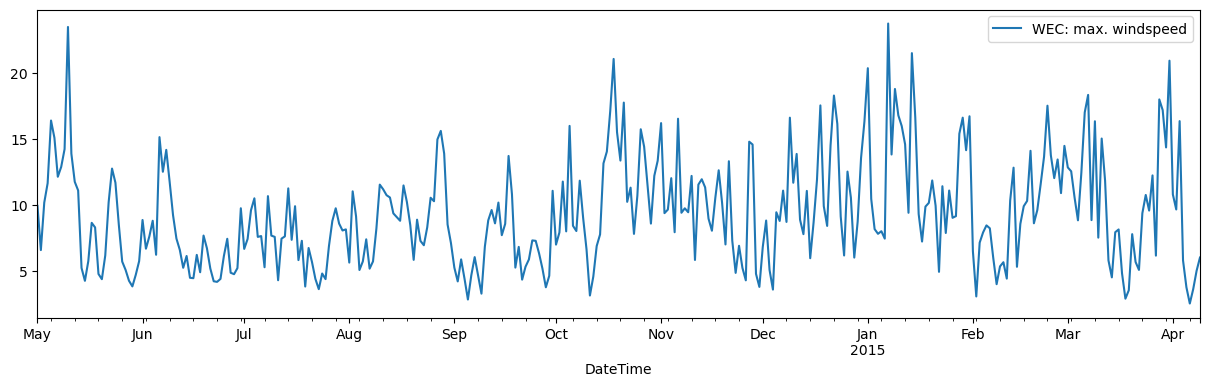

In [11]:
scada_data.resample('D', on='DateTime').mean().plot(y='WEC: max. windspeed', figsize=(15,4))

## WEC: ava. reactive Power over time

<Axes: xlabel='DateTime'>

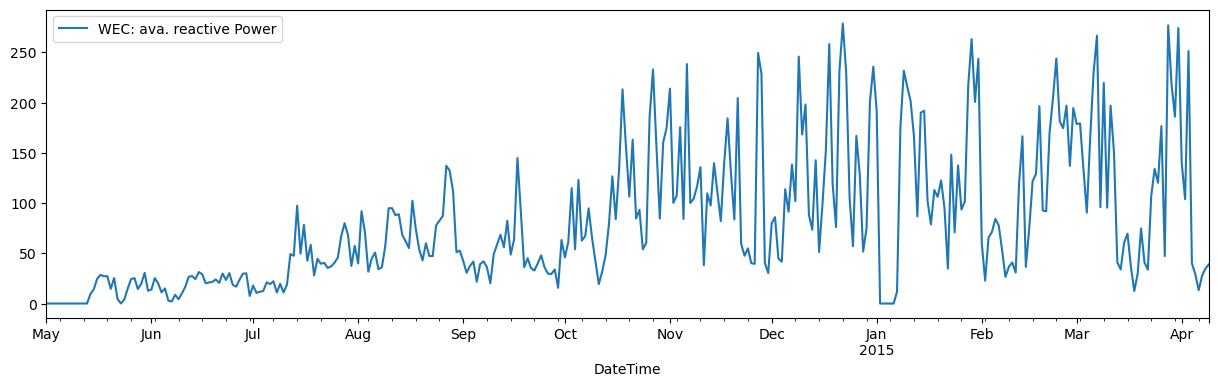

In [15]:
scada_data.resample('D', on='DateTime').mean().plot(y='WEC: ava. reactive Power', figsize=(15,4))

### Turbine Rotation Speed - Average rotation speed (WEC: ava. Rotation) vs windspeed to examine mechanical response to wind conditions.


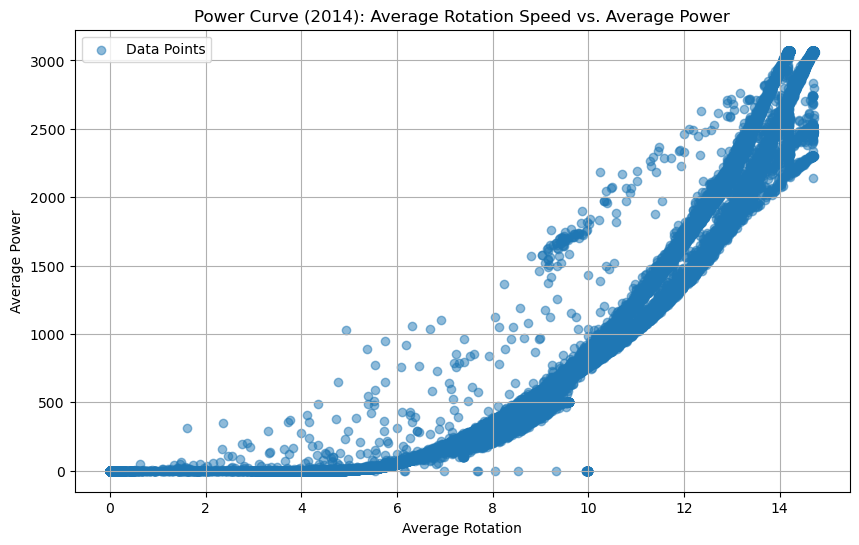

In [14]:
# Extracting relevant columns for the power curve
x_rotation = scada_data['WEC: ava. Rotation']
y_power = scada_data['WEC: ava. Power']

# Plotting the power curve
plt.figure(figsize=(10, 6))
plt.scatter(x_rotation, y_power, alpha=0.5, label="Data Points")
plt.title('Power Curve (2014): Average Rotation Speed vs. Average Power')
plt.xlabel('Average Rotation')
plt.ylabel('Average Power')
plt.grid(True)
plt.legend()
plt.show()

In [18]:
# Ensure the 'WEC: Production kWh' column exists
if 'WEC: Production kWh' in scada_data.columns:
    # Calculate the energy change while handling nulls
    scada_data['Energy Change'] = scada_data['WEC: Production kWh'].fillna(method='ffill').diff()

    # Retain nulls in the new column where the original column had nulls
    scada_data.loc[scada_data['WEC: Production kWh'].isnull(), 'Energy Change'] = None
else:
    logger.error("'WEC: Production kWh' column is missing from the dataset.")

<Figure size 1200x800 with 0 Axes>

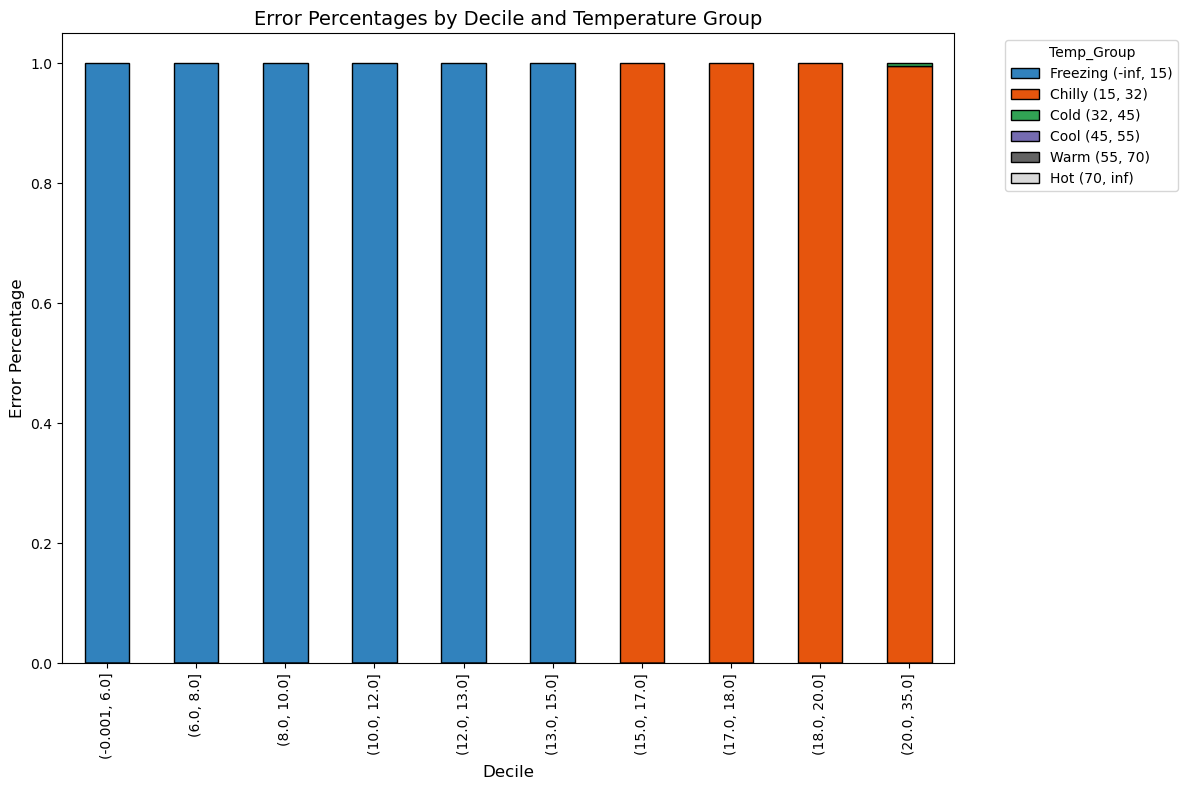

In [16]:
# Create temperature groups for analysis
temperature_bins = [-float('inf'), 15, 32, 45, 55, 70, float('inf')]
temperature_labels = ['Freezing (-inf, 15)', 'Chilly (15, 32)', 'Cold (32, 45)', 
                      'Cool (45, 55)', 'Warm (55, 70)', 'Hot (70, inf)']
scada_data['Temp_Group'] = pd.cut(scada_data['Ambient temp.'], bins=temperature_bins, labels=temperature_labels)

# Calculate error percentages by decile and temperature group
scada_data['Decile'] = pd.qcut(scada_data['Ambient temp.'], q=10, duplicates='drop')
error_percentage = scada_data.groupby(['Decile', 'Temp_Group']).size() / scada_data.groupby(['Decile']).size()
error_percentage = error_percentage.unstack()

# Plotting Error Percentages by Decile and Temperature Group
plt.figure(figsize=(12, 8))
error_percentage.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20c', edgecolor='black')
plt.title('Error Percentages by Decile and Temperature Group', fontsize=14)
plt.xlabel('Decile', fontsize=12)
plt.ylabel('Error Percentage', fontsize=12)
plt.legend(title='Temp_Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

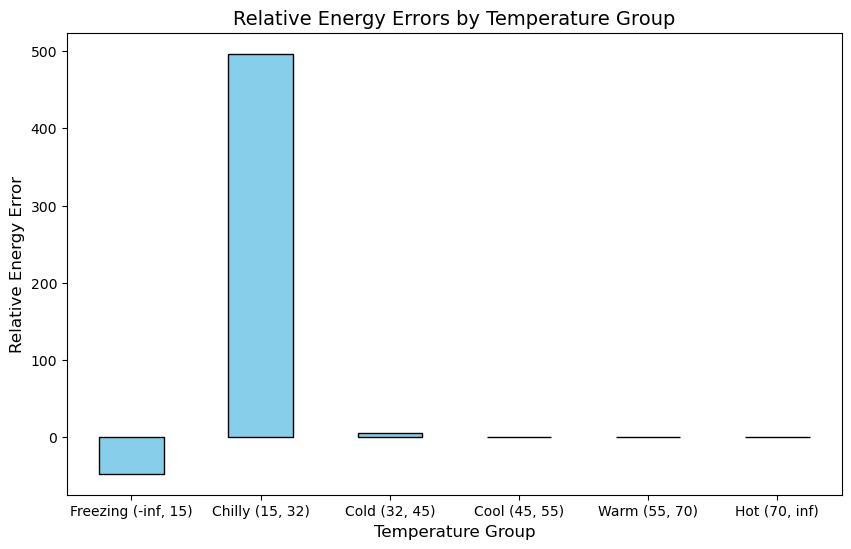

In [19]:
# Calculate relative energy error by temperature group
energy_error_by_temp = scada_data.groupby('Temp_Group')['Energy Change'].sum() / scada_data.groupby('Temp_Group').size()

# Plotting Relative Energy Errors by Temperature Group
plt.figure(figsize=(10, 6))
energy_error_by_temp.plot(kind='bar', color='skyblue', edgecolor='black', rot=0)
plt.title('Relative Energy Errors by Temperature Group', fontsize=14)
plt.xlabel('Temperature Group', fontsize=12)
plt.ylabel('Relative Energy Error', fontsize=12)
plt.tight_layout

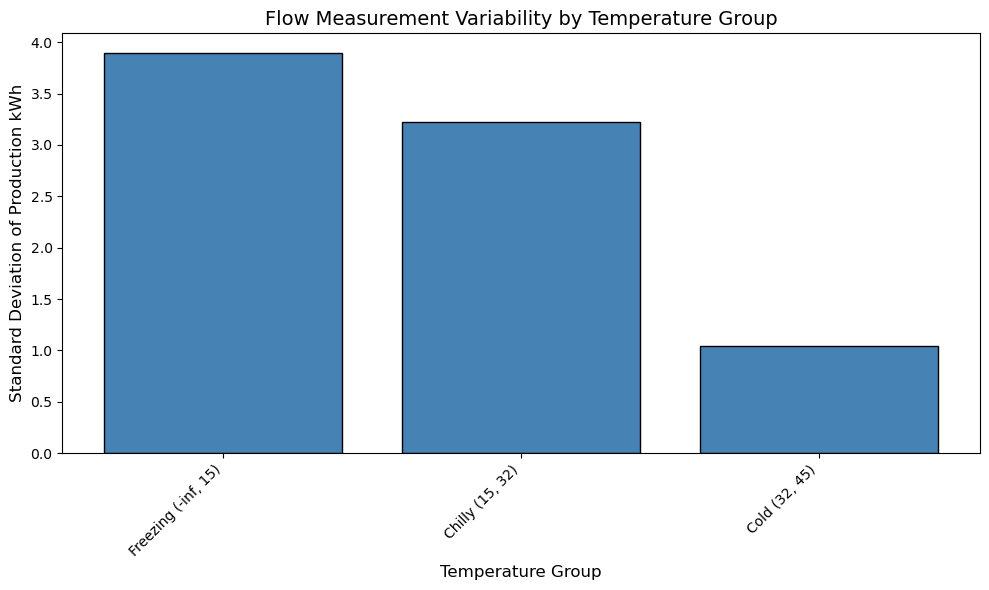

In [22]:
# Analyze variability in flow measurement (e.g., WEC: Production kWh) across temperature groups
flow_variability = scada_data.groupby('Temp_Group')['WEC: ava. windspeed'].agg(['mean', 'std']).reset_index()

# Plotting flow measurement variability by temperature group
plt.figure(figsize=(10, 6))
plt.bar(flow_variability['Temp_Group'], flow_variability['std'], color='steelblue', edgecolor='black')
plt.title('Flow Measurement Variability by Temperature Group', fontsize=14)
plt.xlabel('Temperature Group', fontsize=12)
plt.ylabel('Standard Deviation of Production kWh', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

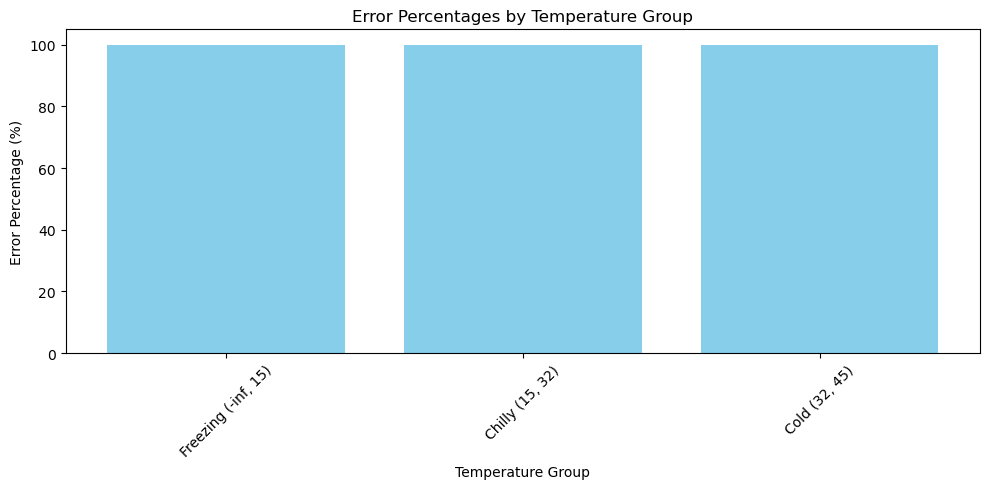

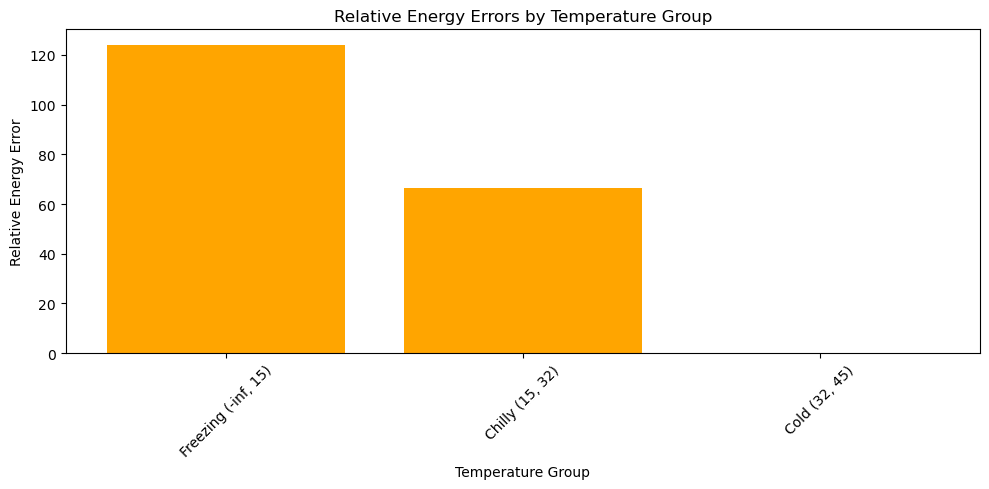

In [25]:
# Step 1: Define temperature categories
temperature_bins = [-np.inf, 15, 32, 45, 55, 70, np.inf]
temperature_labels = ['Freezing (-inf, 15)', 'Chilly (15, 32)', 'Cold (32, 45)', 
                      'Cool (45, 55)', 'Warm (55, 70)', 'Hot (70, inf)']

# Create a new column categorizing ambient temperature
scada_data['Temperature Group'] = pd.cut(scada_data['Ambient temp.'], 
                                         bins=temperature_bins, 
                                         labels=temperature_labels)

# Step 2: Calculate error percentages and relative energy errors
# Assuming 'Error' column indicates operational anomalies, compute error rates
error_counts = scada_data.groupby('Temperature Group')['WEC: ava. Rotation'].count()
total_counts = scada_data['Temperature Group'].value_counts()
error_percentages = (error_counts / total_counts) * 100

# Relative energy error calculation (difference between available power and produced power)
scada_data['Relative Energy Error'] = (scada_data['WEC: ava. available P from wind'] -
                                       scada_data['WEC: ava. Power']).abs()
relative_energy_errors = scada_data.groupby('Temperature Group')['Relative Energy Error'].mean()

# Step 3: Plot the graphs
# Left Graph: Error Percentages by Temperature Group
plt.figure(figsize=(10, 5))
plt.bar(temperature_labels, error_percentages, color='skyblue')
plt.title("Error Percentages by Temperature Group")
plt.xlabel("Temperature Group")
plt.ylabel("Error Percentage (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Right Graph: Relative Energy Errors by Temperature Group
plt.figure(figsize=(10, 5))
plt.bar(temperature_labels, relative_energy_errors, color='orange')
plt.title("Relative Energy Errors by Temperature Group")
plt.xlabel("Temperature Group")
plt.ylabel("Relative Energy Error")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


  0%|          | 0/50 [00:00<?, ?it/s]

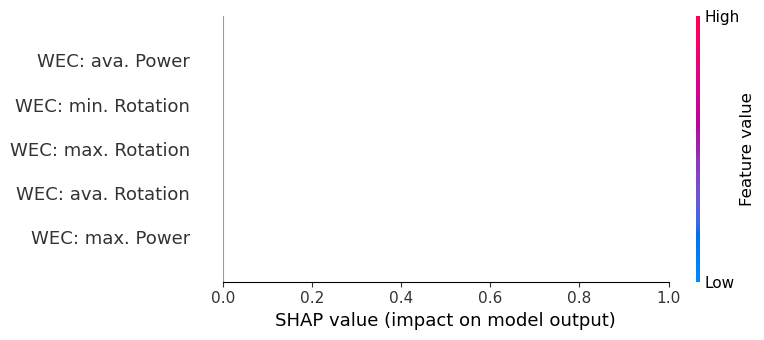

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap

# Step 1: Prepare the dataset
# Select relevant features and target variable
selected_features = ['WEC: min. Rotation', 'WEC: max. Power', 'WEC: ava. Power',
                     'WEC: ava. Rotation', 'WEC: max. Rotation']
target_variable = 'WEC: ava. Power'

# Drop rows with missing values in the selected columns
scada_data_cleaned = scada_data.dropna(subset=selected_features + [target_variable])

# Split into features and target
X = scada_data_cleaned[selected_features]
y = scada_data_cleaned[target_variable]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Step 3: Use SHAP's KernelExplainer to compute SHAP values (CPU-based method)
explainer = shap.KernelExplainer(model.predict, X_train_scaled[:100])  # Use a sample to speed up
shap_values = explainer.shap_values(X_test_scaled[:50])  # Use a sample for explanation

# Step 4: Plot SHAP summary
shap.summary_plot(shap_values, X_test_scaled[:50], feature_names=selected_features, plot_type="compact_dot")


In [27]:
shap_values

array([[ 1.75000000e-03, -1.83333334e-04, -3.23519300e+02,
         1.31666667e-03, -2.08333333e-03],
       [ 1.80000000e-03, -2.33333334e-04, -1.03452080e+03,
         1.11666667e-03, -3.83333334e-04],
       [ 1.75000000e-03,  1.05333333e-02,  3.96447867e+02,
         7.00000001e-04,  1.06500000e-02],
       [ 1.80000000e-03, -2.33333334e-04, -7.49520800e+02,
         1.11666667e-03, -3.83333333e-04],
       [ 4.03333333e-03,  1.88333333e-03,  6.94503050e+02,
        -1.72666667e-02, -2.00000001e-04],
       [ 1.70000000e-03, -2.33333334e-04, -1.06752070e+03,
         1.11666667e-03, -3.83333334e-04],
       [-5.99999999e-04,  8.33333348e-05,  2.00048175e+03,
         7.00000002e-04, -4.33333332e-04],
       [-9.30000000e-03,  1.19500000e-02,  5.17585000e+02,
        -1.26666667e-03, -4.88333333e-03],
       [ 1.80000000e-03, -2.33333334e-04, -5.76520800e+02,
         1.11666667e-03, -3.83333334e-04],
       [ 1.70000000e-03, -2.33333334e-04, -1.06752070e+03,
         1.11666667e-03